In [6]:
root="C:/github/2023/RatDeconvolution"
path_package="C:/github/enan"

## Preparation of rat gene ontology data

In [7]:
filein = f"{root}/data/rgd.gaf" # from the web site: www.geneontology.org
datafile = f'{root}/data/220801_go.owl' # from the web site: www.geneontology.org
depth=5 # gene ontology depth for enrichment analysis

In [8]:
import csv
from collections import deque, defaultdict

import numpy as np
import pandas as pd


import owlready2
from tqdm import tqdm

In [9]:
class OntologyStructure:
    def __init__(self, datafile, root_term:str):
        """
        constructor
        datafile : str, the url of ontology file
        """
        
        # load datafile
        self.onto = owlready2.get_ontology(datafile).load() # load ontology file (DL from https://www.ebi.ac.uk/efo/)
        print(datafile,"was loaded.")
        
        # determine the roots
        roots = []
        for efo in self.onto.classes(): # EFO0000001 is the root
            if root_term in str(efo):
                roots.append(efo)
        if len(roots) == 0:
            print('the designated root term couldnt be found')
            for efo in self.onto.classed():
                if 'EFO0000001' in str(efo):
                    roots.append(efo)

        # select the first root CAUTION : this must be changed if you use an ontology structure which have multiple roots
        self.root = roots[0] 
        print(self.root, "was determined as root.")
        # with BFS, determine the depth of each GO
        self.min_d = self.__BFS() # 幅優先探索をやってる
        print("Graph structure was obtained.")
        
        self.string_hash = self.__create_string_hash()
        print("String hashtable was created.")
 
    def __BFS(self):
        """
        breadth-first search function
        
        the function to determine the depth of each term
        """
        Q = deque([self.root])
        inf_value = lambda : float('inf')
        min_d = defaultdict(inf_value) # defaultdictでエラーしたらinfを返すようにしている. つまり届かないところ
        min_d[self.root] = 0 # rootの深さは0と定義
        while len(Q)>0:
            v = Q.pop()
            for v1 in self.onto.get_children_of(v): # vの子v1をループ
                if min_d[v1]>10**27: # infより大きい場合. Noneでもいいような. 要するにまだmin_dが定義されていないvの子供が現れた時の判定
                    min_d[v1] = min_d[v] + 1 # min_dがない子供が現れたらvの深さに1段階加えて更新する
                    Q.appendleft(v1) # Qは探索すべきものなので, 新たな階層の探索のために追加する
        return min_d # 木構造を返す: タームを入れるとその深さを返すもの

    def __create_string_hash(self):
        """
        string hash function
        
        create the hashtable to get the class instance corresponding to the given string
        """
        
        string_hash = defaultdict(str)
        for key in self.min_d:
            string_hash[str(key)] = key
        return string_hash

    def get_num(self, depth):
        """
        getting the number of ontology term in a specific level
        depth : int
        """
        count = 0
        for key in self.min_d:
            if self.min_d[key]==depth:
                count+=1
        return count
    
    def get_term(self, depth):
        """
        getting the term in the specific level
        depth :  int
        """
        res = []
        term = []
        for key in self.min_d:
            if self.min_d[key]==depth:
                res.append(str(key))
                term.append(str(key.label[0]))
        return res,term
    
    def get_downstream_ID(self):
        max_depth = max(list(self.min_d.values()))
        print('max depth :',max_depth)
        total_res = []
        total_term = []
        for i in range(1,max_depth+1):
            tmp_res = []
            tmp_term = []
            for key in self.min_d:
                if self.min_d[key]==i:
                    tmp_res.append(str(key))
                    tmp_term.append(str(key.label[0]))
            
            for t in tmp_res:
                total_res.append(t)
            for s in tmp_term:
                total_term.append(s)
        return total_res, total_term
    
    def get_upstream(self, go, depth):
        """
        getting the upstream GO in a specific level
        
        go : GO class instance
        depth : int
        """
        if self.min_d[go]<2:
            return set()
        if self.min_d[go]==2:
            return set([go])
        
        up = set()

        Q = deque([go])
        while len(Q)>0:
            v = Q.pop()
            try:
                for v1 in self.onto.get_parents_of(v):
                    if self.min_d[v1]==depth:
                        up.add(v1)
                    else:
                        Q.appendleft(v1)
            except:
                pass
            
        return up
    
    def str2go(self, string):
        """
        str to GO class instance
        """
        return self.string_hash[string]

    def go2str(self, go):
        """
        GO class instance to str
        """
        return str(go)

    def get_depth(self, go):
        """
        get the depth of GO
        """
        return self.min_d[go]
        
    def get_term(self, depth):
        """
        getting the term in the specific level
        depth :  int
        """
        res = []
        term = []
        for key in self.min_d:
            if self.min_d[key]==depth:
                res.append(str(key))
                term.append(str(key.label[0]))
        return res,term
    
    def get_downstream(self, go):
        """
        getting the deepest downstream go terms
        go : GO class instancce
        """
        res = []
        Q = deque(self.onto.get_children_of(go))
        if len(Q)==0:
            return [go]
        
        while len(Q)>0:
            v = Q.pop()
            res.append(v)
            v_child = self.onto.get_children_of(v)
            if len(v_child)==0:
                pass
            else:
                for v1 in v_child:
                    Q.appendleft(v1)
        res = list(set(res))
        return res     

def load_go(gene_dict=dict()):
    terms = []
    members = []
    for key in gene_dict.keys():
        terms.append(key)
        members.append(gene_dict[key])
    return terms, members

def create_dict(datafile='', gene_dict=dict(), depth:int=4):
    # load go.owl file
    dat = OntologyStructure(datafile, 'obo.GO_0008150') #GO_0008150 : Biological Process
    res, term = dat.get_term(depth)
    print('Indicated depth GO terms : {}'.format(len(res)))
    corresp_res = [dat.get_downstream(dat.str2go(i)) for i in tqdm(res)]
    corresp_res = [[str(v).replace('obo.GO_', 'GO:') for v in i] for i in corresp_res]

    # load gene file
    terms, members = load_go(gene_dict=gene_dict)
    #terms = [i.split('(')[1].split(')')[0] for i in terms]
    go_dict = dict(zip(terms, members))
    
    # create dict
    res_dict=dict()
    goperterm=[]
    for root, i, t in zip(res,corresp_res, term):
        res_temp = set()
        for v in i:
            genes_temp=go_dict.get(v, 'no')
            if genes_temp=='no':
                pass
            else:
                res_temp = res_temp or genes_temp
        if len(res_temp)>0:
            res_dict[root.replace('obo.GO_','GO:')+'_'+t]=res_temp
            goperterm.append(len(res_temp))

    print('No. of GO terms : {}'.format(len(res_dict)))
    print('No. of genes / term : {}'.format(np.mean(goperterm)))

    return res_dict

def extract(sentence):
    res = []
    temp1 = sentence.split("RGD\t")
    flag=False
    for i in temp1:
        temp2 = i.split("\t")
        if len(temp2)>5:
            symbol = temp2[1]
            term = temp2[3]
            if "GO:" in term:
                res.append([symbol, term])
                flag=True
    temp1 = sentence.split("UniProtKB\t")
    for i in temp1:
        temp2 = i.split("\t")
        if len(temp2)>5:
            symbol = temp2[1]
            term = temp2[3]
            if "GO:" in term:
                res.append([symbol, term])
                flag=True
    if flag:
        return res, []
    else:
        return res, [sentence]

In [5]:
with open(filein, encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    res = [cols for cols in reader]

res = res[39:]
res_open=[]
res_error1=[]
res_error2=[]
for i in res:
    if type(i)==str:
        res_temp, error = extract(i)
        res_open += res_temp
        res_error1 += error
    elif len(i)==1:
        res_temp, error = extract(i[0])
        res_open += res_temp
        res_error1 += error
    else:
        for v in i:
            if type(v)==str:
                res_temp, error = extract(v)
                res_open += res_temp
                res_error2 += error
            else:
                res_temp, error = extract(v[0])
                res_open += res_temp
                res_error2 += error
e2_go = []
for i in res_error2:
    if "GO" in i:
        e2_go.append(i)

In [6]:
e2_go[:10]

['regulates(GO:0006366)\t',
 '8-sialyltransferase 5\t\tgene\ttaxon:10116\t20220421\tGOC\t\t',
 '8-sialyltransferase 5\t\tgene\ttaxon:10116\t20220421\tGOC\t\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(UBERON:0002421)\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(UBERON:0002421)\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\toccurs_in(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\toccurs_in(GO:0098978)',
 ' member 2\t\tgene\ttaxon:10116\t20050726\tRGD\tnegatively_regulates(GO:0008283)\t']

In [7]:
res_dict = dict()
term_set = set()
for gene, term in res_open:
    if not term in term_set:
        term_set.add(term)
        res_dict[term]=set([gene])
    else:
        res_dict[term].add(gene)

In [8]:
res = create_dict(datafile=datafile, gene_dict=res_dict, depth=depth)

C:/github/2023/RatDeconvolution/data/220801_go.owl was loaded.
obo.GO_0008150 was determined as root.
Graph structure was obtained.
String hashtable was created.
Indicated depth GO terms : 6712


100%|██████████| 6712/6712 [00:00<00:00, 8434.59it/s] 


No. of GO terms : 3447
No. of genes / term : 7.559036843632144


In [9]:
pd.to_pickle(res, f"{root}/result/go_rat_depth5.pickle")

## ssGSEA

In [10]:
# import
import sys
import warnings

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import copy
import codecs

sys.path.append("C:/github/enan")
from enan import binom, ssgsea

warnings.simplefilter('ignore')

In [11]:
def annotation_sample(df, df_b):
    temp = df_b.loc[df.columns.tolist()]
    name = temp["COMPOUND_NAME"].tolist()
    dose = temp["DOSE_LEVEL"].tolist()
    time = temp["SACRIFICE_PERIOD"].tolist()
    ind = [f"{i}_{j}_{k}" for i, j, k in zip(name, dose, time)]
    return ind

def load_transcriptome(target_compounds):
    # load transcriptome
    df_target = pd.read_csv(f"{root}/data/tggate_transcriptome.csv",index_col=0)
    df_sample = pd.read_csv(f"{root}/data/tggate_sample_information.csv",index_col=0)
    df_target.columns=[str(i) for i in df_target.columns]
    df_sample.index=[str(i) for i in df_sample.index]
    df_target.columns = annotation_sample(df_target, df_sample)
    target_lst = [
        f'{compound}_{conc}_{time}'
        for compound in target_compounds 
        for conc in ["High", "Control"]
        for time in ["3 hr", "6 hr", "9 hr", "24 hr"]
    ]
    df_target=df_target.loc[:,target_lst]
    return df_target

def calc_ssGSEA(df, depth=5, limit=10):
    # load
    set_depth = pd.read_pickle(f"{root}/result/go_rat_depth{str(depth)}.pickle")
    ref = dict()
    set_whole=set()
    for i in set_depth.keys():
        temp = set_depth[i]
        if len(temp)>limit-1:
            ref[i]=temp
            set_whole = set_whole|set_depth[i]
    print(f"ref length: {len(ref)}")
    print(f"whole genes: {len(set_whole)}")

    dat = ssgsea.ssGSEA()
    dat.fit(ref)
    dat.set_whole(set_whole)
    res = dat.calc(df, method="kuiper")
    return res

In [12]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]


In [13]:
df = load_transcriptome(target_compounds)
col = df.columns.tolist()
df.columns=range(len(df.columns))

In [14]:
res = calc_ssGSEA(df, depth=5)
res.columns=col

ref length: 584
whole genes: 8098
Kuiper method


100%|██████████| 383/383 [07:04<00:00,  1.11s/it]


In [15]:
res.to_csv(f"{root}/result/res_depth5_kuiper.csv")

## Analysis/Visualization

In [65]:
import copy
import warnings

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.stats.multitest as sm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = 16
warnings.simplefilter('ignore')

In [66]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

In [67]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]

clusters = [
    ["naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril","gefitinib","metformin","tiopronin",],
    ["colchicine","bortezomib","methylene dianiline","galactosamine","thioacetamide",],
    ["LPS","cycloheximide"],["tacrine","nitrofurazone"],
]
depth=5
limit=0.05

## Statistical Test of Features

In [68]:
# Deconvolution
res = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
res = res.loc[(res.index.str.contains("High")) | (res.index.str.contains("Control")),:]
res = res.loc[~(res.index.str.contains("day")),:]
res_z = calc_z(res, drugs=target_compounds, ctrl="Control")

In [69]:
df_res = pd.DataFrame()
for tar, con in itertools.combinations_with_replacement([0,1,2,3], 2):
    if tar!=con:
        p_vals=[]
        lst_name = []
        for time in ["3 hr", "6 hr", "9 hr", "24 hr"]:
            lst_tar=[f"{comp}_High_{time}" for comp in clusters[tar]]
            lst_con=[f"{comp}_High_{time}" for comp in clusters[con]]
            for target in ["Neu", "Mon", "CD4T", "CD8T"]:
                p_val = stats.ttest_ind(res_z.loc[lst_tar,target].values,res_z.loc[lst_con,target].values,equal_var=False)[1]
                p_vals.append(p_val)
                lst_name.append(f"{target}_{time}")
        p_vals = [float(str(i).replace('nan','1')) for i in p_vals]
        q_vals = sm.multipletests(p_vals, alpha=0.1, method='fdr_bh')[1]
        # Export
        df_res[f"q_{tar}{con}"]=q_vals
df_res.index=lst_name
df_res = df_res.fillna(1)

In [70]:
df_res

,q_01,q_02,q_03,q_12,q_13,q_23
Neu_3 hr,2.010543e-04,5.172089e-03,0.029377,1.047456e-02,0.300374,0.014043
Mon_3 hr,5.035399e-01,5.040874e-02,0.634184,8.112801e-02,0.925791,0.077434
CD4T_3 hr,3.685115e-01,2.037843e-02,0.458056,2.226411e-02,0.444967,0.036052
CD8T_3 hr,1.411697e-03,3.243071e-03,0.100654,1.403254e-02,0.439522,0.008814
Neu_6 hr,1.350920e-04,1.870204e-05,0.048920,4.051253e-05,0.955339,0.000010
Mon_6 hr,3.099044e-05,5.366802e-01,0.777767,9.426693e-03,0.000239,0.624987
CD4T_6 hr,1.411697e-03,9.829377e-04,0.634184,3.059086e-03,0.031205,0.001105
CD8T_6 hr,3.824257e-07,1.203179e-07,0.048920,2.715813e-06,0.010001,0.000002
Neu_9 hr,1.316747e-02,6.851852e-04,0.001497,1.236020e-03,0.215943,0.001878
Mon_9 hr,4.280376e-04,8.405216e-01,0.634184,4.266940e-02,0.000650,0.624987


## Statistical Test of ssGSEA scores

In [87]:
def plot_go_violin(res_temp, lst_all, term:str="", ax="", position=0):
    df_temp = pd.DataFrame()
    names = [[f"Cluster{cluster}/ {hrs}hr" for cluster in [1,2,3,4]] for hrs in [3,6,9,24]]
    colors=[
        "salmon",
        "lightblue",
        "lightgreen",
        "violet",
    ]
    names=["Ctrl"]+names[position]
    for i in [lst_all[0]]+lst_all[4*position+1:4*(position+1)+1]:
        temp = res_temp.loc[term, i].values.flatten()
        df_temp = pd.concat([df_temp, pd.DataFrame(temp)], axis=1)

    df_temp.columns=names
    sns.violinplot(x='variable', y='value', data=df_temp.melt(), dodge=True,
                jitter=True, color='black', palette=["grey"]+colors, ax=ax)
    
    ax.axhline(y=df_temp["Ctrl"].median(), color="grey", linestyle="dashed")
    ax.set_xticks(range(5))
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.set_ylabel('ssGSEA Score', fontsize=16)
    ax.set_xlim(-1,5)
    str_go, str_name = term.split("_")
    str_name1 = str_name.rsplit(" ", 2)
    if len(str_name1)>2:
        ax.set_title(f"{str_go}\n{str_name1[0]}\n{str_name1[1]} {str_name1[2]}", fontsize=16)
    else:
        ax.set_title(f"{str_go}\n{str_name1[0]}\n{str_name1[1]}", fontsize=16)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.grid(False)

In [72]:
res = pd.read_csv(f"{root}/result/res_depth{depth}_kuiper.csv", index_col=0)
res.columns = [i.split(".")[0] for i in res.columns]

In [73]:
lst_control = [f"{comp}_Control_{time}" for time in ["3 hr", "6 hr", "9 hr", "24 hr"] for cluster in clusters for comp in cluster]
lst_clusters = [[f"{comp}_High_{time}" for comp in cluster] for time in ["3 hr", "6 hr", "9 hr", "24 hr"] for cluster in clusters]
lst_all = [lst_control]
lst_all.extend(lst_clusters)
labels = []
target_lst=[]
for i, lst in enumerate(lst_all):
    labels+=[i]*len(lst)
    target_lst.extend(lst)

res_temp = copy.deepcopy(res)
res_temp = res_temp.loc[:,target_lst]

In [74]:
target_numbers=range(1,17)
df_res = pd.DataFrame(index=res.index)
def test(df_tar, df_con):
    FoldC = df_tar.median(axis=1) / df_con.median(axis=1) 
    p_vals = [stats.ttest_ind(df_tar.loc[ind,:],df_con.loc[ind,:],equal_var=False)[1] for ind in res.index.tolist()]
    p_vals = [float(str(i).replace('nan','1')) for i in p_vals]
    q_vals = sm.multipletests(p_vals, alpha=0.1, method='fdr_bh')[1]    
    return q_vals, FoldC   

for tar in target_numbers:
    df_tar = res_temp.loc[:,lst_all[tar]]
    counter=list(range(((tar-1)//4)*4+1, ((tar-1)//4)*4+5))
    counter.remove(tar)
    temp_lst=[]
    for i in counter:
        temp_lst+=lst_all[i]
    df_con = res_temp.loc[:,temp_lst]
    q_vals, FoldC = test(df_tar, df_con)
    # Export
    df_res[f"q_{tar}_rest"]=q_vals
    df_res[f"FC_{tar}_rest"]=FoldC.values

    df_con = res_temp.loc[:,lst_all[0]]
    q_vals, FoldC = test(df_tar, df_con)
    # Export
    df_res[f"q_{tar}_ctrl"]=q_vals
    df_res[f"FC_{tar}_ctrl"]=FoldC.values

df_res = df_res.fillna(1)
temp = df_res.loc[:,df_res.columns.str.contains("q")]
df_res_limit = df_res.loc[~((temp>limit).sum(axis=1) == len(temp.columns)),:] 
df_res_limit["q_min"]=df_res_limit.min(axis=1)

In [75]:
# Cluster 1, 6 hrs
df_res_limit.sort_values(by=["q_5_rest"]).head(10)

,q_1_rest,FC_1_rest,q_1_ctrl,FC_1_ctrl,q_2_rest,FC_2_rest,q_2_ctrl,FC_2_ctrl,q_3_rest,FC_3_rest,...,FC_14_ctrl,q_15_rest,FC_15_rest,q_15_ctrl,FC_15_ctrl,q_16_rest,FC_16_rest,q_16_ctrl,FC_16_ctrl,q_min
GO:0032965_regulation of collagen biosynthetic process,0.012678,1.060283,0.609938,1.015844,0.484277,0.882428,0.125128,0.872657,0.100712,0.823348,...,0.695941,0.933884,1.015798,0.214101,0.796622,0.657760,1.153038,0.202175,0.885981,4.194095e-09
GO:0072678_T cell migration,0.008365,0.872946,0.067422,1.179834,0.152224,1.203119,0.003117,1.437036,0.155960,1.203964,...,1.664515,0.877600,1.239470,0.290522,1.592847,0.750225,0.796509,0.438101,1.066319,8.307598e-06
GO:0070723_response to cholesterol,0.319880,1.035479,0.461873,0.955763,0.862365,0.976924,0.075132,0.924122,0.148535,0.837527,...,0.688861,0.877600,0.908220,0.267356,0.754350,0.708902,1.003905,0.411840,0.832928,5.161106e-06
GO:0036315_cellular response to sterol,0.319880,1.035479,0.461873,0.955763,0.862365,0.976924,0.075132,0.924122,0.148535,0.837527,...,0.688861,0.877600,0.908220,0.267356,0.754350,0.708902,1.003905,0.411840,0.832928,5.161106e-06
GO:1990440_positive regulation of transcription from RNA polymerase II promoter in response to endoplasmic reticulum stress,0.015676,0.918945,0.978907,1.008279,0.192835,1.081246,0.023178,1.102737,0.176649,1.098785,...,1.189741,0.911625,1.026702,0.426021,1.084955,0.080007,0.877780,0.528636,0.952351,3.680926e-06
GO:0010611_regulation of cardiac muscle hypertrophy,0.103747,0.898418,0.215083,0.943361,0.802446,1.113068,0.485107,1.050024,0.027656,1.626272,...,1.225124,0.903491,1.078126,0.438150,1.168092,0.064365,0.798324,0.384542,0.914124,9.436827e-05
GO:0014741_negative regulation of muscle hypertrophy,0.103747,0.898418,0.215083,0.943361,0.802446,1.113068,0.485107,1.050024,0.027656,1.626272,...,1.225124,0.903491,1.078126,0.438150,1.168092,0.064365,0.798324,0.384542,0.914124,9.436827e-05
GO:0007010_cytoskeleton organization,0.053535,1.123714,0.261029,1.052674,0.616657,0.964136,0.555513,0.955012,0.989593,0.990213,...,0.858079,0.896818,1.041242,0.588110,0.919601,0.428879,0.874582,0.210085,0.779472,1.562531e-04
GO:0070925_organelle assembly,0.053535,1.123714,0.261029,1.052674,0.616657,0.964136,0.555513,0.955012,0.989593,0.990213,...,0.858079,0.896818,1.041242,0.588110,0.919601,0.428879,0.874582,0.210085,0.779472,1.562531e-04
GO:0071391_cellular response to estrogen stimulus,0.040205,0.864086,0.877118,0.979146,0.957957,1.024342,0.269983,1.089383,0.199976,1.146979,...,1.069354,0.609319,0.919444,0.901379,0.999111,0.322826,1.038250,0.125209,1.110257,1.562531e-04


In [76]:
# Cluster 2, 6 hrs
df_res_limit.sort_values(by=["q_6_rest"]).head(10)

,q_1_rest,FC_1_rest,q_1_ctrl,FC_1_ctrl,q_2_rest,FC_2_rest,q_2_ctrl,FC_2_ctrl,q_3_rest,FC_3_rest,...,FC_14_ctrl,q_15_rest,FC_15_rest,q_15_ctrl,FC_15_ctrl,q_16_rest,FC_16_rest,q_16_ctrl,FC_16_ctrl,q_min
GO:0032965_regulation of collagen biosynthetic process,0.012678,1.060283,0.609938,1.015844,0.484277,0.882428,0.125128,0.872657,0.100712,0.823348,...,0.695941,0.933884,1.015798,0.214101,0.796622,0.657760,1.153038,0.202175,0.885981,4.194095e-09
GO:0051403_stress-activated MAPK cascade,0.041510,0.914453,0.171397,0.968397,0.095121,1.133699,0.073166,1.099809,0.701903,1.017167,...,1.107113,0.643231,1.062044,0.255415,1.073233,0.050148,0.812452,0.122209,0.848298,2.156671e-04
GO:0070723_response to cholesterol,0.319880,1.035479,0.461873,0.955763,0.862365,0.976924,0.075132,0.924122,0.148535,0.837527,...,0.688861,0.877600,0.908220,0.267356,0.754350,0.708902,1.003905,0.411840,0.832928,5.161106e-06
GO:0036315_cellular response to sterol,0.319880,1.035479,0.461873,0.955763,0.862365,0.976924,0.075132,0.924122,0.148535,0.837527,...,0.688861,0.877600,0.908220,0.267356,0.754350,0.708902,1.003905,0.411840,0.832928,5.161106e-06
GO:0032400_melanosome localization,0.150096,1.049459,0.171397,0.952682,0.433193,0.916812,0.043089,0.869965,0.519919,0.956106,...,0.955329,0.633259,1.084658,0.922456,1.038070,0.657760,1.015141,0.353374,0.973152,1.000911e-04
GO:0072678_T cell migration,0.008365,0.872946,0.067422,1.179834,0.152224,1.203119,0.003117,1.437036,0.155960,1.203964,...,1.664515,0.877600,1.239470,0.290522,1.592847,0.750225,0.796509,0.438101,1.066319,8.307598e-06
GO:0032402_melanosome transport,0.150096,1.049459,0.171397,0.952682,0.433193,0.916812,0.043089,0.869965,0.519919,0.956106,...,0.955329,0.633259,1.084658,0.922456,1.038070,0.657760,1.015141,0.353374,0.973152,1.000911e-04
GO:0048245_eosinophil chemotaxis,0.041680,1.135303,0.771547,0.966546,0.076683,0.844652,0.001583,0.816396,0.092179,0.813628,...,0.881643,0.982186,0.971052,0.688817,0.960351,0.567998,1.098907,0.966510,1.056943,8.801196e-04
GO:0072677_eosinophil migration,0.041680,1.135303,0.771547,0.966546,0.076683,0.844652,0.001583,0.816396,0.092179,0.813628,...,0.881643,0.982186,0.971052,0.688817,0.960351,0.567998,1.098907,0.966510,1.056943,8.801196e-04
GO:0009648_photoperiodism,0.767198,1.092803,0.168324,0.960188,0.911153,0.935093,0.071734,0.873951,0.160674,0.839851,...,0.905638,0.903491,1.053613,0.882949,0.983682,0.590143,1.079295,0.988577,1.001880,2.351119e-04


In [77]:
# Cluster 3, 9 hrs
df_res_limit.sort_values(by=["q_11_rest"]).head(10)

,q_1_rest,FC_1_rest,q_1_ctrl,FC_1_ctrl,q_2_rest,FC_2_rest,q_2_ctrl,FC_2_ctrl,q_3_rest,FC_3_rest,...,FC_14_ctrl,q_15_rest,FC_15_rest,q_15_ctrl,FC_15_ctrl,q_16_rest,FC_16_rest,q_16_ctrl,FC_16_ctrl,q_min
GO:0034341_response to interferon-gamma,0.031322,0.879184,0.891552,1.012152,0.844627,1.109598,0.046464,1.151240,0.050992,1.477127,...,1.278049,0.952226,0.997600,0.467345,1.110696,0.140804,0.827198,0.743733,0.940598,6.053487e-15
GO:0001838_embryonic epithelial tube formation,0.470179,1.047751,0.858544,1.021448,0.862365,0.967786,0.634545,0.984736,0.052746,0.815811,...,0.971657,0.805851,0.933147,0.620139,0.953017,0.198341,1.045419,0.288262,1.043549,6.053487e-15
GO:0060337_type I interferon signaling pathway,0.960108,1.031414,0.527323,1.017957,0.392095,0.956783,0.577175,0.975403,0.107075,1.152984,...,1.098132,0.988325,1.047398,0.761221,1.062190,0.449819,0.959885,0.850199,0.979908,1.253797e-10
GO:0001676_long-chain fatty acid metabolic process,0.918542,0.978181,0.993819,1.010197,0.095121,1.080472,0.073166,1.079152,0.052746,0.766072,...,0.904019,0.877600,0.976432,0.488449,0.884887,0.140804,0.924566,0.071493,0.845906,2.188934e-08
GO:0033559_unsaturated fatty acid metabolic process,0.918542,0.978181,0.993819,1.010197,0.095121,1.080472,0.073166,1.079152,0.052746,0.766072,...,0.904019,0.877600,0.976432,0.488449,0.884887,0.140804,0.924566,0.071493,0.845906,2.188934e-08
GO:0048536_spleen development,0.541644,1.027553,0.380878,0.959336,0.566989,1.077614,0.651970,0.982916,0.028160,0.765916,...,0.947015,0.463811,0.891919,0.255415,0.869437,0.153886,1.212865,0.259021,1.155549,5.269191e-08
GO:0007265_Ras protein signal transduction,0.769194,1.025998,0.127293,0.976604,0.717175,0.935778,0.122498,0.913885,0.304643,0.944174,...,0.827324,0.596787,0.863767,0.214101,0.763847,0.248841,1.071713,0.128332,0.920403,6.716714e-07
GO:0006743_ubiquinone metabolic process,0.979371,0.982873,0.653191,0.975157,0.862365,1.008608,0.987633,0.989852,0.085120,0.902573,...,1.036029,0.982186,0.980011,0.339997,1.011667,0.657760,1.056527,0.381144,1.086716,1.404955e-06
GO:0034612_response to tumor necrosis factor,0.031322,0.913461,0.271005,1.051817,0.862365,1.035093,0.046464,1.148873,0.043236,1.417706,...,1.358425,0.799803,1.169589,0.390794,1.184682,0.011591,0.839214,0.203853,0.931220,1.669887e-06
GO:0050953_sensory perception of light stimulus,0.145871,0.951390,0.240929,0.966496,0.717175,0.949394,0.543419,0.952245,0.114783,1.143040,...,1.073910,0.430234,1.121611,0.214101,1.169001,0.007104,0.863040,0.076065,0.913844,6.258430e-06


In [78]:
# Cluster 4, 9 hrs
df_res_limit.sort_values(by=["q_12_rest"]).head(10)

,q_1_rest,FC_1_rest,q_1_ctrl,FC_1_ctrl,q_2_rest,FC_2_rest,q_2_ctrl,FC_2_ctrl,q_3_rest,FC_3_rest,...,FC_14_ctrl,q_15_rest,FC_15_rest,q_15_ctrl,FC_15_ctrl,q_16_rest,FC_16_rest,q_16_ctrl,FC_16_ctrl,q_min
GO:0050847_progesterone receptor signaling pathway,0.727655,0.930879,0.676403,0.942974,0.250841,1.171843,0.296370,1.105017,0.650247,1.050923,...,0.939335,0.892827,1.015408,0.790393,0.945909,0.039944,0.964521,0.000004,0.912349,0.000004
GO:0001921_positive regulation of receptor recycling,0.463711,0.967542,0.331445,0.974742,0.924306,0.991903,0.629424,0.980493,0.203121,0.954157,...,0.991210,0.821315,1.008288,0.267356,1.065823,0.013229,1.158649,0.018002,1.222020,0.000228
GO:0097062_dendritic spine maintenance,0.542005,1.069449,0.947539,1.024286,0.860886,0.935546,0.561047,0.957770,0.007773,0.862247,...,0.886142,0.517920,0.864940,0.214101,0.810495,0.089577,1.243909,0.326033,1.130307,0.000170
GO:0036035_osteoclast development,0.603092,1.022396,0.420811,1.031673,0.802483,0.976664,0.913894,0.998281,0.990959,0.983261,...,0.893657,0.880825,1.037280,0.283422,0.957866,0.555121,0.945542,0.137919,0.885765,0.000129
GO:1900262_regulation of DNA-directed DNA polymerase activity,0.928385,1.002168,0.689363,1.047991,0.681993,0.997837,0.269983,1.045724,0.188297,1.112513,...,1.324603,0.988325,1.063632,0.320085,1.212174,0.162565,0.798081,0.819378,0.960204,0.000520
GO:0006686_sphingomyelin biosynthetic process,0.968399,0.998248,0.891083,0.982863,0.574312,1.051359,0.373462,1.018798,0.537704,1.029546,...,0.941473,0.687164,1.080566,0.535184,1.037514,0.124122,0.935884,0.128332,0.931671,0.000580
GO:2000344_positive regulation of acrosome reaction,0.968399,0.964677,0.336672,0.958293,0.786557,1.037926,0.753245,0.994637,0.275580,1.065536,...,1.073795,0.907298,1.006322,0.883468,1.014674,0.023844,0.859027,0.068159,0.885815,0.001077
GO:0032663_regulation of interleukin-2 production,0.727655,0.966867,0.821132,0.974721,0.658242,1.054332,0.675024,1.027680,0.036664,1.144638,...,1.467916,0.799803,1.148927,0.281547,1.410995,0.251916,0.854615,0.613040,1.104143,0.000008
GO:0034612_response to tumor necrosis factor,0.031322,0.913461,0.271005,1.051817,0.862365,1.035093,0.046464,1.148873,0.043236,1.417706,...,1.358425,0.799803,1.169589,0.390794,1.184682,0.011591,0.839214,0.203853,0.931220,0.000002
GO:1990403_embryonic brain development,0.983282,0.964047,0.588785,0.943896,0.924306,1.032665,0.413074,0.992124,0.944189,0.976739,...,0.915769,0.635958,0.920481,0.214101,0.812593,0.094934,1.165794,0.891118,0.994405,0.001713


q_5_rest


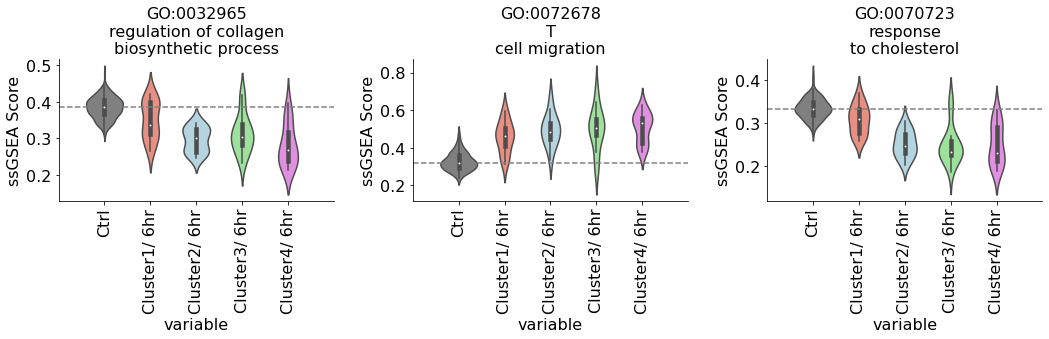

q_6_rest


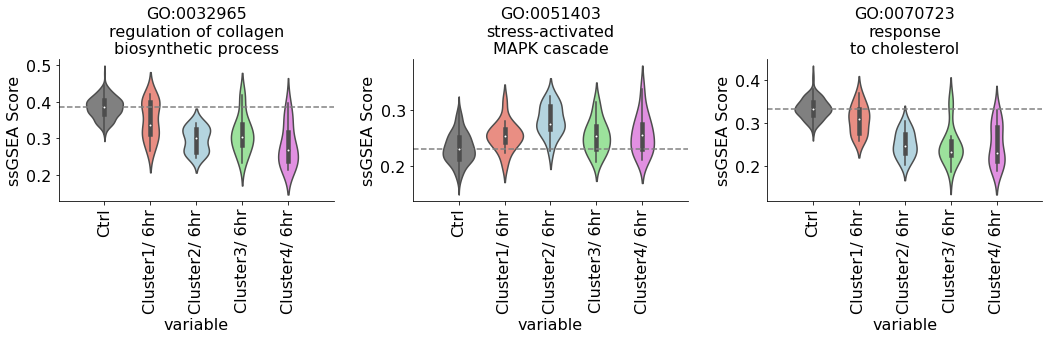

q_11_rest


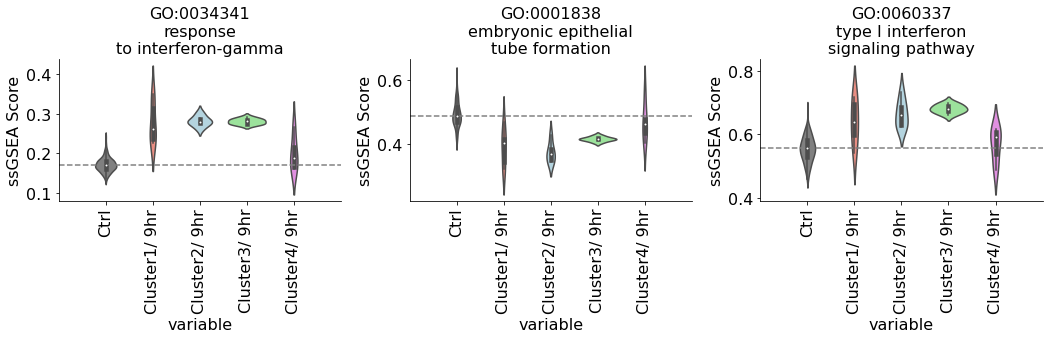

q_12_rest


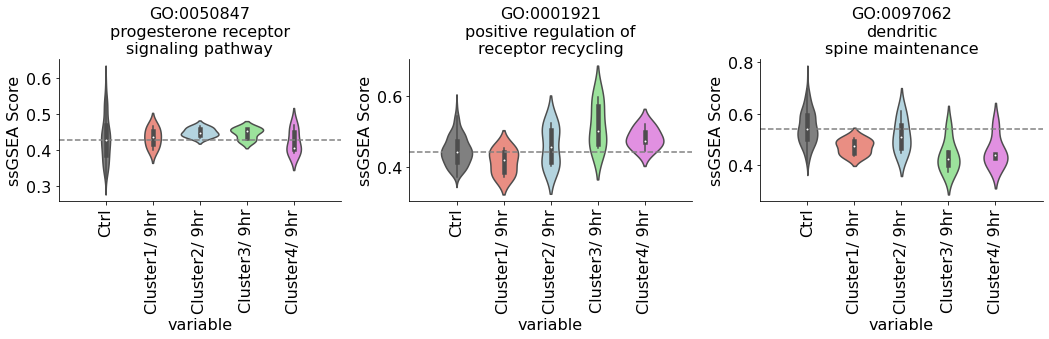

In [88]:
lst_name = [
    ["q_5_rest",1],
    ["q_6_rest",1],
    ["q_11_rest",2],
    ["q_12_rest",2],
]

for name,i in lst_name:
    print(name)
    fig = plt.figure(figsize=(15,5))
    terms = df_res_limit.sort_values(by=[name]).index.tolist()[:3]
    for v, term in enumerate(terms):
        ax=fig.add_subplot(1,3,v+1)
        plot_go_violin(res_temp, lst_all=lst_all, term=term, ax=ax, position=i)
    plt.tight_layout()
    plt.show()    

In [82]:
term="GO:0035728_response to hepatocyte growth factor"
depth=5

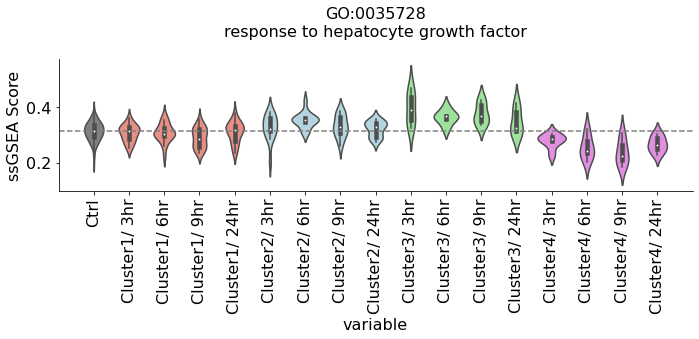

In [83]:
res = pd.read_csv(f"{root}/result/res_depth{depth}_kuiper.csv", index_col=0)
res.columns = [i.split(".")[0] for i in res.columns]

lst_control = [f"{comp}_Control_{time}" for time in ["3 hr", "6 hr", "9 hr", "24 hr"] for cluster in clusters for comp in cluster]
lst_clusters = [[f"{comp}_High_{time}" for comp in cluster] for cluster in clusters for time in ["3 hr", "6 hr", "9 hr", "24 hr"]]
lst_all = [lst_control]
lst_all.extend(lst_clusters)
labels = []
target_lst=[]
for i, lst in enumerate(lst_all):
    labels+=[i]*len(lst)
    target_lst.extend(lst)

res_temp = copy.deepcopy(res)
res_temp = res_temp.loc[:,target_lst]

def plot_go_violin(df, lst_all, term:str="", ax="", position=0):
    df_temp = pd.DataFrame()
    names = [
        "Ctrl", 
        "Cluster1/ 3hr", "Cluster1/ 6hr", "Cluster1/ 9hr", "Cluster1/ 24hr", 
        "Cluster2/ 3hr", "Cluster2/ 6hr", "Cluster2/ 9hr", "Cluster2/ 24hr",
        "Cluster3/ 3hr", "Cluster3/ 6hr", "Cluster3/ 9hr", "Cluster3/ 24hr",
        "Cluster4/ 3hr", "Cluster4/ 6hr", "Cluster4/ 9hr", "Cluster4/ 24hr",]
    colors=[
        ["salmon"]*4,
        ["lightblue"]*4,
        ["lightgreen"]*4,
        ["violet"]*4,
    ]
    colors=[list(i)[0] for i in np.array(colors).reshape(-1,1)]
    for x, i in enumerate(lst_all):
        temp = res_temp.loc[term, i].values.flatten()
        df_temp = pd.concat([df_temp, pd.DataFrame(temp)], axis=1)

    df_temp.columns=names
    sns.violinplot(x='variable', y='value', data=df_temp.melt(), dodge=True,
                jitter=True, color='black', palette=["grey"]+list(colors), ax=ax)
    
    ax.axhline(y=df_temp["Ctrl"].median(), color="grey", linestyle="dashed")
    ax.set_xticks(range(17))
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.set_ylabel('ssGSEA Score', fontsize=16)
    ax.set_xlim(-1,17)
    str_go, str_name = term.split("_")
    ax.set_title(f"{str_go}\n{str_name}\n", fontsize=16)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.grid(False)

fig = plt.figure(figsize=(10,5))
#terms=["GO:0035728_response to hepatocyte growth factor", "GO:0071363_cellular response to growth factor stimulus"]
terms=["GO:0035728_response to hepatocyte growth factor"]
for v, term in enumerate(terms):
    ax=fig.add_subplot(1,1,v+1)
    plot_go_violin(res_temp, lst_all=lst_all, term=term, ax=ax, position=i)
plt.tight_layout()
plt.show()    